In [93]:
import os
from os.path import join
import pandas as pd
import numpy as np
import timeit

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer

# Raw Data

In [94]:
red_wine = os.path.join('data','wine', 'winequality-red.csv')
white_wine = os.path.join('data','wine', 'winequality-white.csv')
turbine = os.path.join('data','turbine','gt_2011.csv')
mushrooms = os.path.join('data','mushroom','secondary_data.csv')

# encoders to use
scale = StandardScaler()
ohe = OneHotEncoder(sparse_output=False)

In [95]:
transformer = make_column_transformer(
    (
        ohe, 
        [
        'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment','gill-spacing', 'gill-color', 
       'stem-root', 'stem-surface', 'stem-color','veil-type', 'veil-color',
        'has-ring', 'ring-type', 'spore-print-color','habitat', 'season'
        ]
        ),
    remainder='passthrough'
    )

# pre-process shroom data

shroom_df = pd.read_csv(mushrooms,sep=';').sample(frac=1).reset_index(drop=True)
x = shroom_df.iloc[:,1:].copy()
x_shroom = pd.DataFrame(transformer.fit_transform(x), 
                columns=transformer.get_feature_names_out())
y = shroom_df.iloc[:,0].copy()
y_shroom = (y == 'p')


# reduce the number of training examples
x_shroom = x_shroom[:7000]
y_shroom =  y_shroom[:7000]

# Scale numerical attributes to be b/w 1 and -1
lst_of_num_cols = [
    'remainder__cap-diameter', 'remainder__stem-height', 'remainder__stem-width'
    ]
x_shroom[lst_of_num_cols] = scale.fit_transform(x_shroom[lst_of_num_cols])

In [96]:
white_df = pd.read_csv(white_wine, sep=';')
red_df = pd.read_csv(red_wine, sep=';')
white_df['type'] = 0
red_df['type'] = 1
wine_df = pd.concat([white_df,red_df])
wine_df = wine_df.sample(frac=1).reset_index(drop=True)

# set x and y values
# remove 'quality' and 'type' column from x array
x_wine = wine_df.iloc[:,:-2].copy()
# scale x vals
x_wine.values[:,:] = scale.fit_transform(x_wine)
# set y array equal to 'type' column 
y_wine = wine_df.iloc[:,-1].copy()

In [4]:
DATA_FOLDER = join('algo_data') 

# Helper Functions

In [168]:
def plot_curve(x_data, y_mean, y_std, axs=None,
                take_mean=True, name='', x_name='num_clusters'):
    axs.set_title(name, fontsize=20)
    axs.tick_params(axis='both', labelsize=20)
    axs.set_xlabel(x_name, fontsize=20)

    if axs == None:
        _, axs = plt.subplots()

    if take_mean:
        axs.plot(x_data,y_mean,'o-')
        line = axs.fill_between(x_data, y_mean + y_std, y_mean - y_std,alpha=0.3)
    else:
        line = axs.plot(x_data, y_mean)

    return line

In [176]:
def plot_bic_curve(x_data, y_mean, y_std, axs=None,
                    take_mean=True, name='', x_name='num_clusters',
                      selected_compoents=1):
    
    axs.set_title(name, fontsize=20)
    axs.tick_params(axis='both', labelsize=20)
    axs.set_xlabel(x_name, fontsize=20)

    if axs == None:
        _, axs = plt.subplots()

    if take_mean:
        line = axs.errorbar(x=x_data,y=y_mean, yerr=y_std, fmt='o')
    else:
        line = axs.scatter(x_data, y_mean)

    # axs.

    return line

In [282]:
def plot_rca_curve(x_data, y_mean, y_std=None, axs=None,
                take_mean=True, name='', x_name='num_components', 
                selected_components=1):
    
    axs.set_title(name,fontsize=20)
    axs.tick_params(axis='both', labelsize=20)
    axs.set_xlabel(x_name,fontsize=20)

    if axs == None:
        _, axs = plt.subplots()

    if take_mean:
        axs.plot(x_data,y_mean,'o-', label=name)
        line = axs.fill_between(x_data, y_mean + y_std, y_mean - y_std,alpha=0.3)
    else:
        line = axs.plot(x_data, y_mean, label=name)
    
    axs.axvline(selected_components, linestyle=':',
                c='orange', label=f'{selected_components} chosen\ncomponents',lw=3)
    axs.legend(fontsize=15)

    return line

In [286]:
def plot_dr_clust_curve(x_data, y_mean, y_std, axs=None,
                take_mean=True, name='', x_name='num_clusters',
                selected_components=1, label='KM'):
    axs.set_title(name, fontsize=20)
    axs.tick_params(axis='both', labelsize=20)
    axs.set_xlabel(x_name, fontsize=20)

    if axs == None:
        _, axs = plt.subplots()

    if take_mean:
        axs.plot(x_data,y_mean,'o-')
        line = axs.fill_between(x_data, y_mean + y_std, y_mean - y_std,alpha=0.3)
    else:
        line = axs.plot(x_data, y_mean)

    axs.axvline(x=selected_components,color='orange',
                        linestyle=':', label=label, lw=3)
    axs.legend(fontsize=20)

    return line

# Read in Data

## Clustering Results

In [15]:
## read wine results

df_km_wine = pd.read_csv(join(DATA_FOLDER,'df_km_wine.csv'))
s_km_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_km_cluster_wine.csv'))
x_km_wine= pd.read_csv(join(DATA_FOLDER,'x_km_wine.csv'))

df_em_wine= pd.read_csv(join(DATA_FOLDER,'df_em_wine.csv'))
df_em_score_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_wine.csv'))
s_em_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_wine.csv'))
x_em_wine= pd.read_csv(join(DATA_FOLDER,'x_em_wine.csv'))

In [16]:
## read shroom results

df_km_shroom = pd.read_csv(join(DATA_FOLDER,'df_km_shroom.csv'))
s_km_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_km_cluster_shroom.csv'))
x_km_shroom= pd.read_csv(join(DATA_FOLDER,'x_km_shroom.csv'))

df_em_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_shroom.csv'))
df_em_score_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_score_shroom.csv'))
s_em_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_shroom.csv'))
x_em_shroom= pd.read_csv(join(DATA_FOLDER,'x_em_shroom.csv'))

## Dimension Reduction Results

In [17]:
# dimension reduced wine dataset
df_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_pca_wine.csv'))
s_pca_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_pca_cluster_wine.csv'))
x_pca_wine= pd.read_csv(join(DATA_FOLDER,'x_pca_wine.csv'))

df_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_rca_wine.csv'))
s_rca_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_rca_cluster_wine.csv'))
x_rca_wine= pd.read_csv(join(DATA_FOLDER,'x_rca_wine.csv'))

df_man_wine= pd.read_csv(join(DATA_FOLDER,'df_man_wine.csv'))
s_man_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_man_cluster_wine.csv'))
x_man_wine= pd.read_csv(join(DATA_FOLDER,'x_man_wine.csv'))

In [18]:
# dimension reduced shroom dataset
df_pca_shroom= pd.read_csv(join(DATA_FOLDER,'df_pca_shroom.csv'))
s_pca_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_pca_cluster_shroom.csv'))
x_pca_shroom= pd.read_csv(join(DATA_FOLDER,'x_pca_shroom.csv'))

df_rca_shroom= pd.read_csv(join(DATA_FOLDER,'df_rca_shroom.csv'))
s_rca_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_rca_cluster_shroom.csv'))
x_rca_shroom= pd.read_csv(join(DATA_FOLDER,'x_rca_shroom.csv'))

df_man_shroom= pd.read_csv(join(DATA_FOLDER,'df_man_shroom.csv'))
s_man_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_man_cluster_shroom.csv'))
x_man_shroom= pd.read_csv(join(DATA_FOLDER,'x_man_shroom.csv'))

## Clustering on DRed datasets

In [19]:
## read in clustering on dimension reduced wine set
df_km_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_km_pca_wine.csv'))
s_km_pca_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_km_pca_cluster_wine.csv'))
x_km_pca_wine= pd.read_csv(join(DATA_FOLDER,'x_km_pca_wine.csv'))

df_em_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_pca_wine.csv'))
df_em_score_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_pca_wine.csv'))
s_em_cluster_pca_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_pca_wine.csv'))
x_em_pca_wine= pd.read_csv(join(DATA_FOLDER,'x_em_pca_wine.csv'))

df_km_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_km_rca_wine.csv'))
s_km_rca_cluster_wine= pd.read_csv(join(DATA_FOLDER,'df_km_rca_wine.csv'))
x_km_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_km_rca_wine.csv'))

df_em_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_rca_wine.csv'))
df_em_score_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_rca_wine.csv'))
s_em_cluster_rca_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_rca_wine.csv')) 
x_em_rca_wine= pd.read_csv(join(DATA_FOLDER,'x_em_rca_wine.csv'))

df_km_man_wine= pd.read_csv(join(DATA_FOLDER,'df_km_man_wine.csv'))
s_km_man_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_km_man_cluster_wine.csv'))
x_km_man_wine= pd.read_csv(join(DATA_FOLDER,'df_km_man_wine.csv'))

df_em_man_wine= pd.read_csv(join(DATA_FOLDER,'df_km_man_wine.csv'))
df_em_score_man_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_man_wine.csv'))
s_em_cluster_man_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_man_wine.csv'))
x_em_man_wine= pd.read_csv(join(DATA_FOLDER,'x_em_man_wine.csv'))

In [20]:
## read in clustering on dimension reduced wine set
df_km_pca_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_pca_shroom.csv'))
s_km_pca_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_km_pca_cluster_shroom.csv'))
x_km_pca_shroom= pd.read_csv(join(DATA_FOLDER,'x_km_pca_shroom.csv'))

df_em_pca_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_pca_shroom.csv'))
df_em_score_pca_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_score_pca_shroom.csv'))
s_em_cluster_pca_shroom= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_pca_shroom.csv'))
x_em_pca_shroom= pd.read_csv(join(DATA_FOLDER,'x_em_pca_shroom.csv'))

df_km_rca_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_rca_shroom.csv'))
s_km_rca_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_rca_shroom.csv'))
x_km_rca_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_rca_shroom.csv'))

df_em_rca_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_rca_shroom.csv'))
df_em_score_rca_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_score_rca_shroom.csv'))
s_em_cluster_rca_shroom= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_rca_shroom.csv')) 
x_em_rca_shroom= pd.read_csv(join(DATA_FOLDER,'x_em_rca_shroom.csv'))

df_km_man_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_man_shroom.csv'))
s_km_man_cluster_shroom= pd.read_csv(join(DATA_FOLDER,'s_km_man_cluster_shroom.csv'))
x_km_man_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_man_shroom.csv'))

df_em_man_shroom= pd.read_csv(join(DATA_FOLDER,'df_km_man_shroom.csv'))
df_em_score_man_shroom= pd.read_csv(join(DATA_FOLDER,'df_em_score_man_shroom.csv'))
s_em_cluster_man_shroom= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_man_shroom.csv'))
x_em_man_shroom= pd.read_csv(join(DATA_FOLDER,'x_em_man_shroom.csv'))

## Read in Neural Net Results

# Visualizations

## Clustering on Raw Data

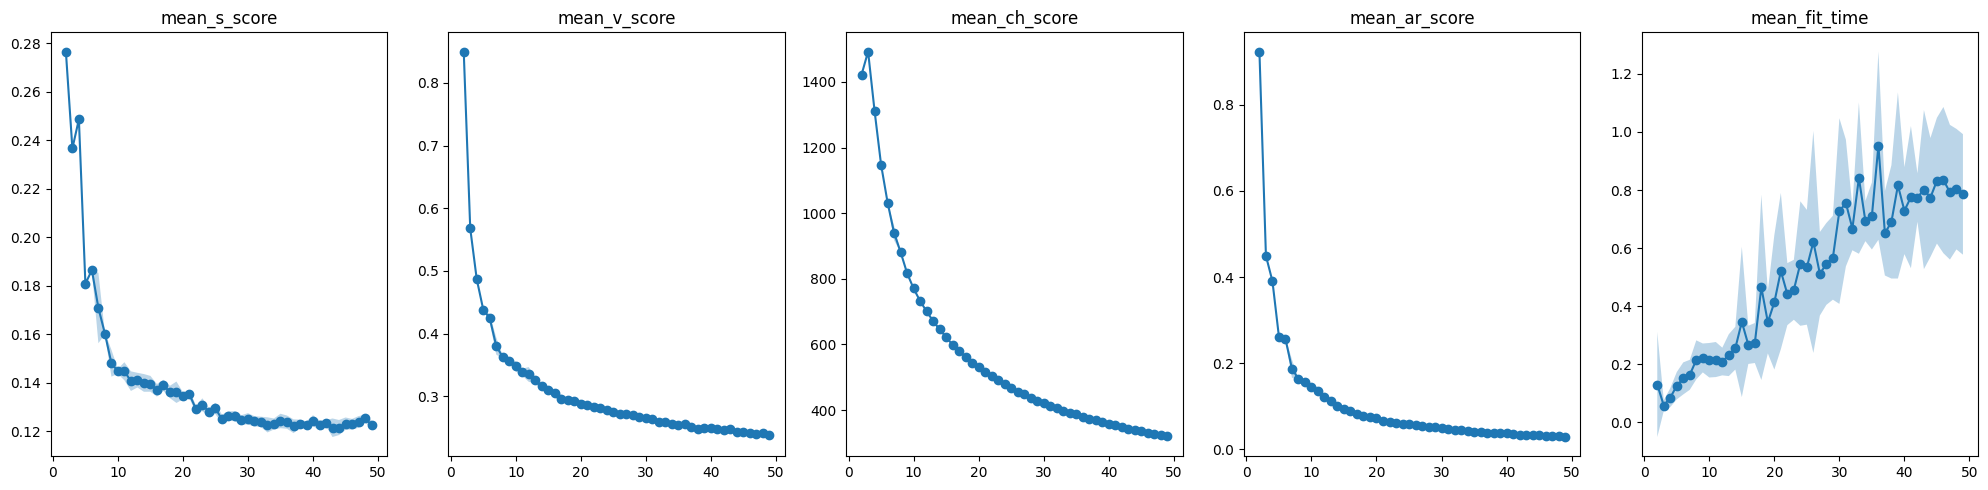

In [41]:
## K Means Clustering Results
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'
    y_mean = df_km_wine[col_name]
    y_std = df_km_wine[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    count=count+1

y_mean = df_km_wine['mean_fit_time']
y_std = df_km_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
plt.tight_layout()
plt.show()

In [43]:
df_em_score_wine.columns.unique()

Index(['Unnamed: 0', 'num_clusters', 'mean_fit_time', 'std_fit_time',
       'mean_s_score', 'std_s_score', 'mean_v_score', 'std_v_score',
       'mean_ch_score', 'std_ch_score', 'mean_ar_score', 'std_ar_score'],
      dtype='object')

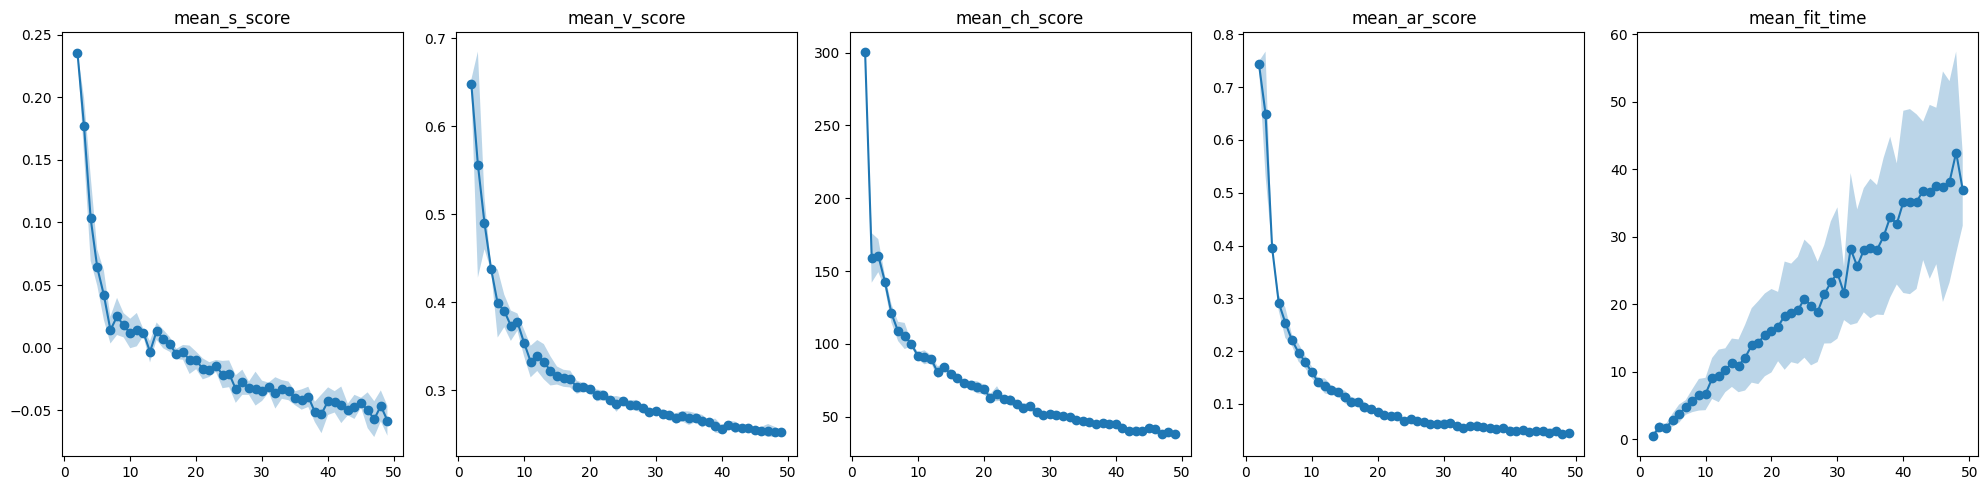

In [44]:
## EM Clustering Results
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_em_score_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'
    y_mean = df_em_score_wine[col_name]
    y_std = df_em_score_wine[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    count=count+1

y_mean = df_em_score_wine['mean_fit_time']
y_std = df_em_score_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
plt.tight_layout()
plt.show()

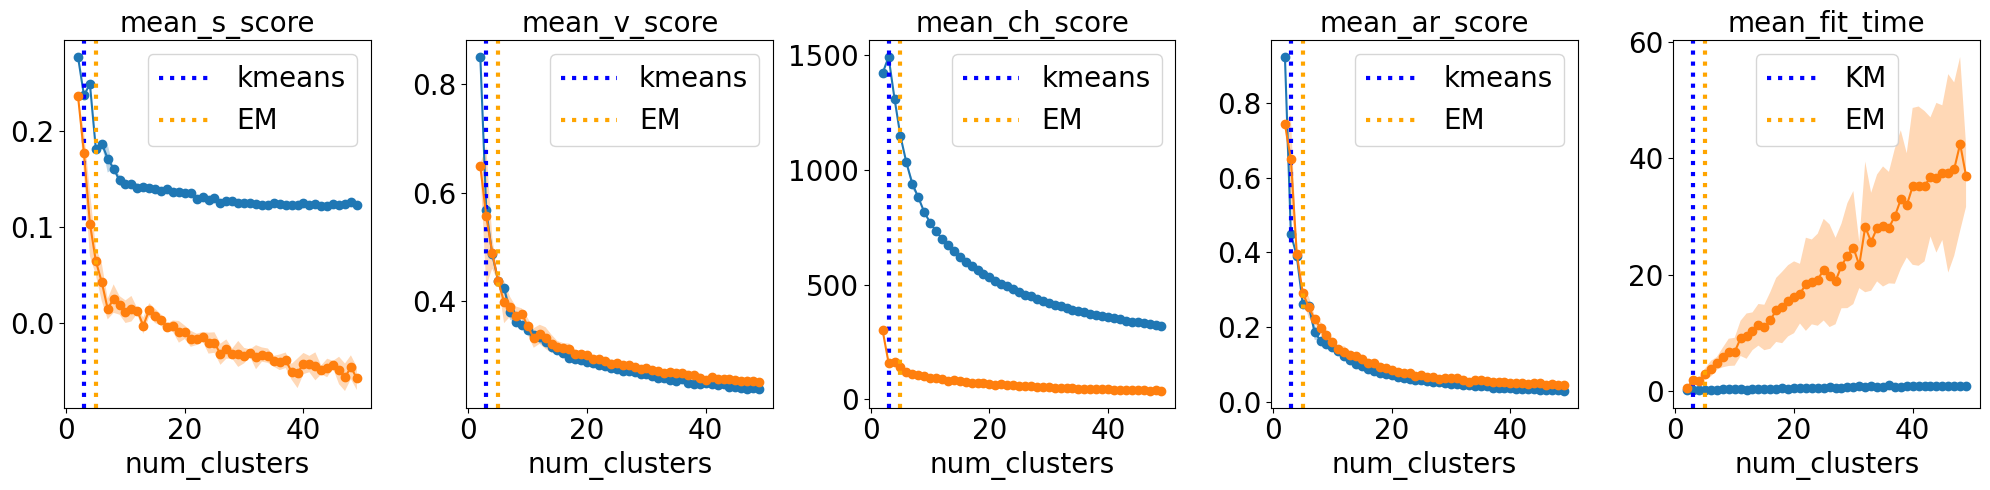

In [171]:
## K Means Clustering Results
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    y_mean = df_km_wine[col_name]
    y_std = df_km_wine[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    axs[count].axvline(x=s_km_cluster_wine.iloc[0,1], color='blue',
                        linestyle=':', label='kmeans', lw=3)

    # EM plot
    y_mean = df_em_score_wine[col_name]
    y_std = df_em_score_wine[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    axs[count].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='EM', lw=3)
    axs[count].legend(fontsize=20)
    # increment index counter for axes array
    count=count+1

# plot fit time for km
y_mean = df_km_wine['mean_fit_time']
y_std = df_km_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
axs[-1].axvline(x=s_km_cluster_wine.iloc[0,1],color='blue',
                        linestyle=':', label='KM', lw=3)

# plot fit time for em
y_mean = df_em_score_wine['mean_fit_time']
y_std = df_em_score_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
axs[-1].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='EM', lw=3)
axs[-1].legend(fontsize=20)

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

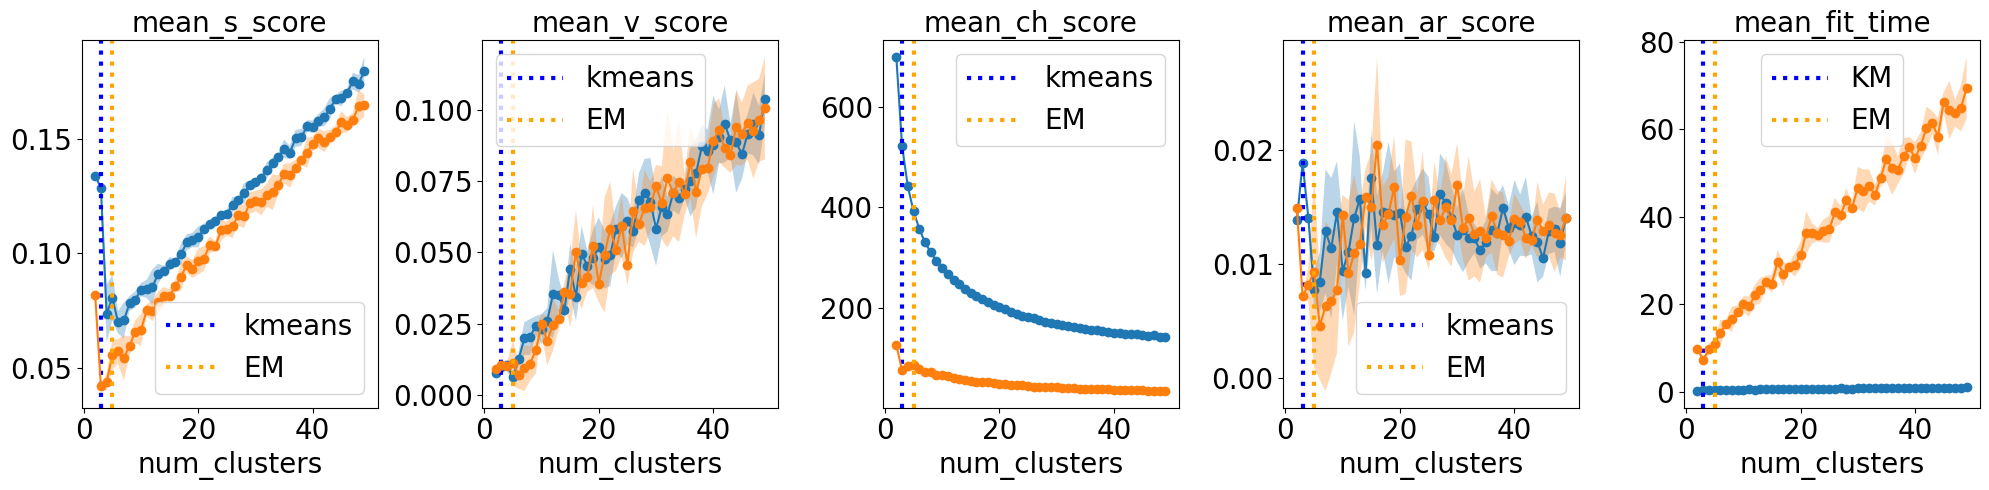

In [170]:
## Clustering Results for Shroom
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_shroom['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    y_mean = df_km_shroom[col_name]
    y_std = df_km_shroom[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    axs[count].axvline(x=s_km_cluster_wine.iloc[0,1], color='blue',
                        linestyle=':', label='kmeans', lw=3)

    # EM plot
    y_mean = df_em_score_shroom[col_name]
    y_std = df_em_score_shroom[std_name]
    plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[count], name=col_name)
    axs[count].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='EM', lw=3)
    axs[count].legend(fontsize=20)
    # increment index counter for axes array
    count=count+1

# plot fit time for km
y_mean = df_km_shroom['mean_fit_time']
y_std = df_km_shroom['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
axs[-1].axvline(x=s_km_cluster_wine.iloc[0,1],color='blue',
                        linestyle=':', label='KM', lw=3)

# plot fit time for em
y_mean = df_em_score_shroom['mean_fit_time']
y_std = df_em_score_shroom['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')
axs[-1].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='EM', lw=3)
axs[-1].legend(fontsize=20)

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

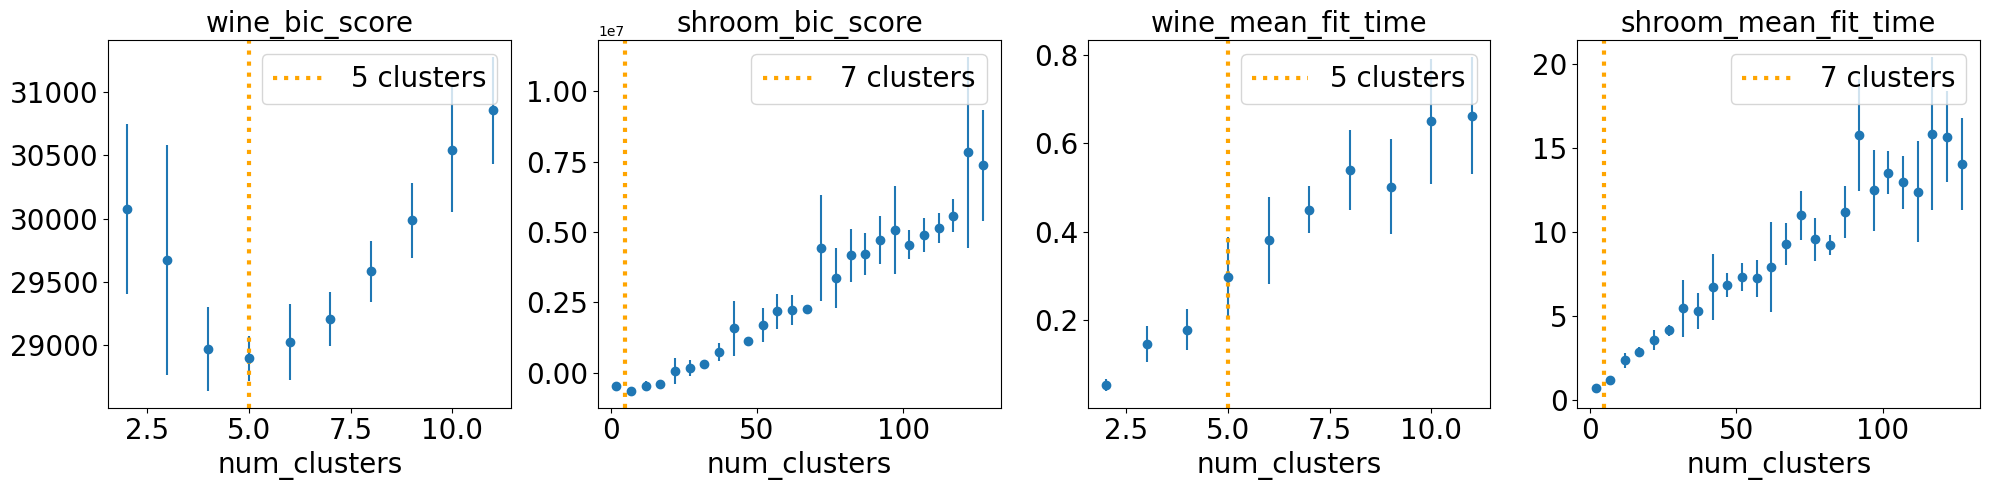

In [182]:
# BIC score for wine
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs= axs.flatten()
x_data = df_em_wine['n_components']
y_mean = df_em_wine['bic_score']
y_std = df_em_wine['std_bic_score']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[0], name='wine_bic_score')

y_mean = df_em_wine['mean_fit_time']
y_std = df_em_wine['std_fit_time']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[2], name='wine_mean_fit_time')

x_data = df_em_shroom['n_components']
y_mean = df_em_shroom['mean_fit_time']
y_std = df_em_shroom['std_fit_time']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[3], name='shroom_mean_fit_time')

y_mean = df_em_shroom['bic_score']
y_std = df_em_shroom['std_bic_score']
plot_bic_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[1], name='shroom_bic_score')


axs[0].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='5 clusters', lw=3)

axs[1].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='7 clusters', lw=3)

axs[2].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='5 clusters', lw=3)

axs[3].axvline(x=s_em_cluster_wine.iloc[0,1],color='orange',
                        linestyle=':', label='7 clusters', lw=3)

axs[0].legend(fontsize=20)
axs[1].legend(fontsize=20)
axs[2].legend(fontsize=20)
axs[3].legend(fontsize=20)
plt.tight_layout()
plt.show()

## Dimension Reduction

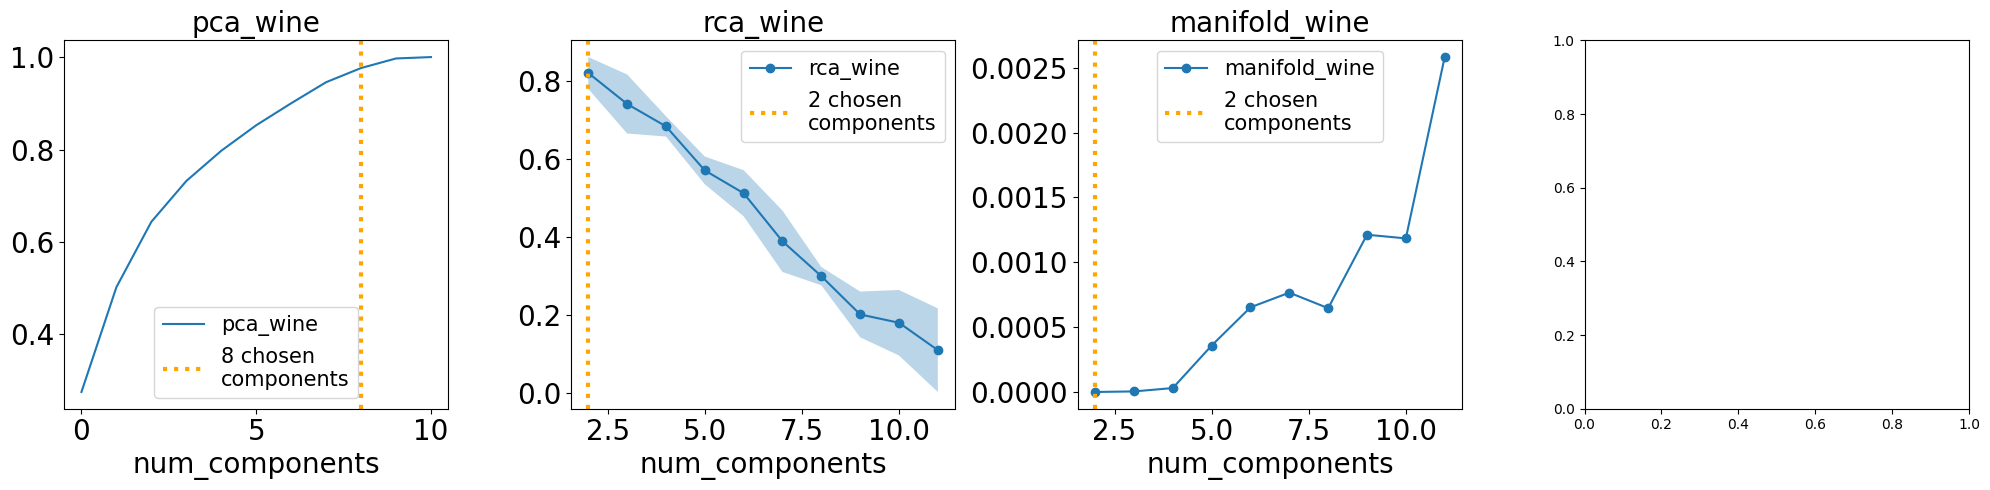

In [283]:
# wine DR
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs =axs.flatten()

x_data = df_pca_wine.index
y_mean = df_pca_wine['0']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[0], name='pca_wine', take_mean=False,
                selected_components=s_pca_cluster_wine.iloc[0,-1])

x_data = df_rca_wine['num_components']
y_mean = df_rca_wine['mean_recon_error']
y_std =df_rca_wine['std_recon_error']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[1], name='rca_wine', take_mean=True,
                 selected_components=s_rca_cluster_wine.iloc[0,-1] )

x_data = df_man_wine['num_components']
y_mean = df_man_wine['mean_recon_error']
y_std =df_man_wine['std_recon_error']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[2], name='manifold_wine', take_mean=True,
                  selected_components=s_man_cluster_wine.iloc[0,-1])

plt.tight_layout()
plt.show()

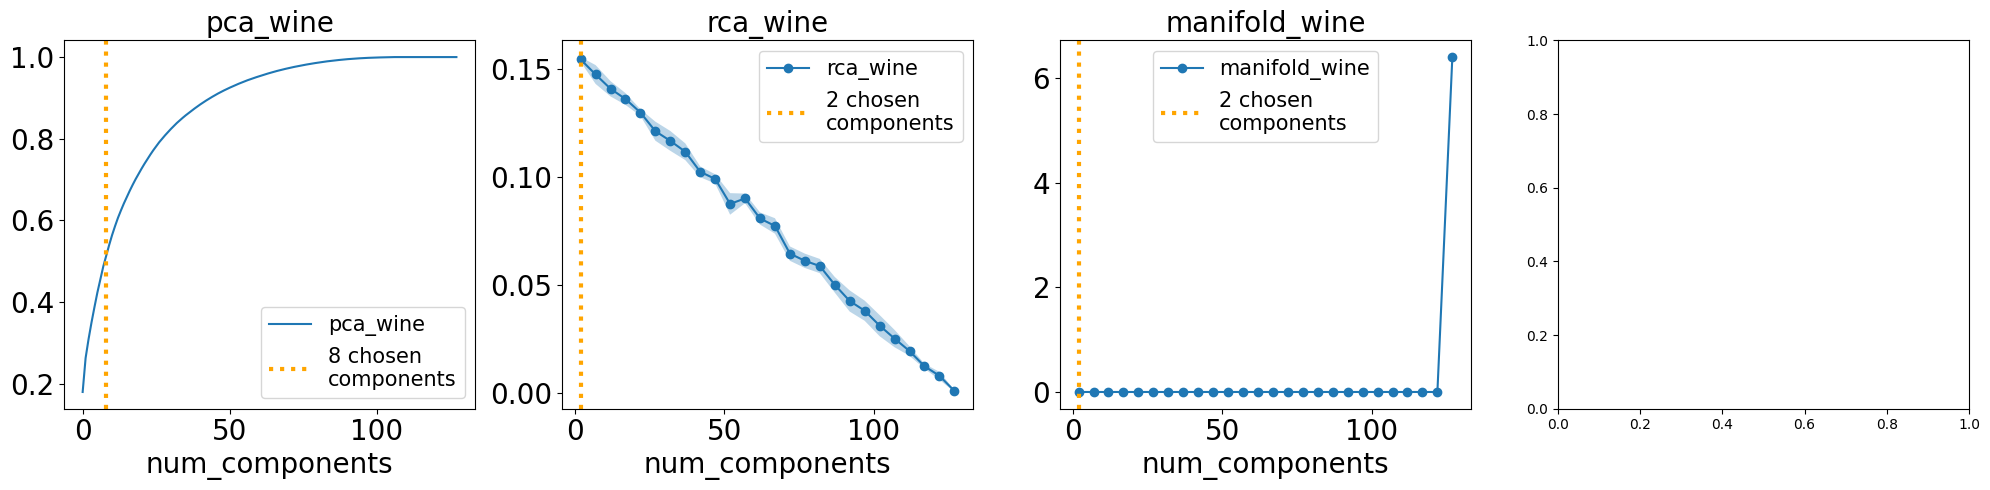

In [284]:
# wine DR
fig, axs = plt.subplots(1,4, figsize=(20,5))
axs =axs.flatten()

x_data = df_pca_shroom.index
y_mean = df_pca_shroom['0']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[0], name='pca_wine', take_mean=False,
                selected_components=s_pca_cluster_wine.iloc[0,-1])

x_data = df_rca_shroom['num_components']
y_mean = df_rca_shroom['mean_recon_error']
y_std =df_rca_shroom['std_recon_error']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[1], name='rca_wine', take_mean=True,
                 selected_components=s_rca_cluster_wine.iloc[0,-1] )

x_data = df_man_shroom['num_components']
y_mean = df_man_shroom['mean_recon_error']
y_std =df_man_shroom['std_recon_error']

plot_rca_curve(x_data=x_data, y_mean=y_mean, y_std=y_std,
                axs=axs[2], name='manifold_wine', take_mean=True,
                  selected_components=s_man_cluster_wine.iloc[0,-1])

plt.tight_layout()
plt.show()

## Clustering on Dimension Reduced Data

In [ ]:
## read in clustering on dimension reduced wine set
df_km_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_km_pca_wine.csv'))
s_km_pca_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_km_pca_cluster_wine.csv'))
x_km_pca_wine= pd.read_csv(join(DATA_FOLDER,'x_km_pca_wine.csv'))

df_em_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_pca_wine.csv'))
df_em_score_pca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_pca_wine.csv'))
s_em_cluster_pca_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_pca_wine.csv'))
x_em_pca_wine= pd.read_csv(join(DATA_FOLDER,'x_em_pca_wine.csv'))

df_km_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_km_rca_wine.csv'))
s_km_rca_cluster_wine= pd.read_csv(join(DATA_FOLDER,'df_km_rca_wine.csv'))
x_km_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_km_rca_wine.csv'))

df_em_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_rca_wine.csv'))
df_em_score_rca_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_rca_wine.csv'))
s_em_cluster_rca_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_rca_wine.csv')) 
x_em_rca_wine= pd.read_csv(join(DATA_FOLDER,'x_em_rca_wine.csv'))

df_km_man_wine= pd.read_csv(join(DATA_FOLDER,'df_km_man_wine.csv'))
s_km_man_cluster_wine= pd.read_csv(join(DATA_FOLDER,'s_km_man_cluster_wine.csv'))
x_km_man_wine= pd.read_csv(join(DATA_FOLDER,'df_km_man_wine.csv'))

df_em_man_wine= pd.read_csv(join(DATA_FOLDER,'df_km_man_wine.csv'))
df_em_score_man_wine= pd.read_csv(join(DATA_FOLDER,'df_em_score_man_wine.csv'))
s_em_cluster_man_wine= pd.read_csv(join(DATA_FOLDER,'s_em_cluster_man_wine.csv'))
x_em_man_wine= pd.read_csv(join(DATA_FOLDER,'x_em_man_wine.csv'))

KeyError: 'mean_s_score'

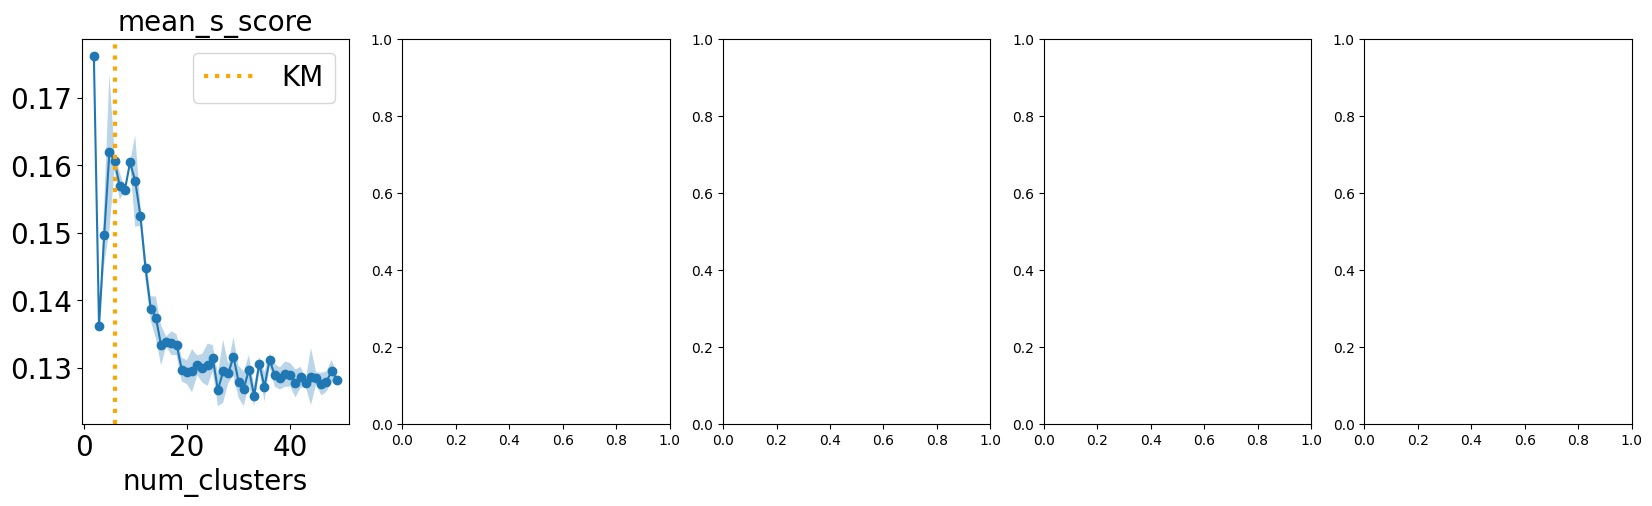

In [288]:
## clustering results pca
fig, axs = plt.subplots(nrows=1,ncols=5, figsize=(20,5))
axs = axs.flatten()
score_lst = ['s', 'v', 'ch', 'ar']
x_data = df_km_pca_wine['num_clusters']
count = 0
for name in score_lst:
    col_name = f'mean_{name}_score'
    std_name = f'std_{name}_score'

    # kmeans plot
    y_mean = df_km_pca_wine[col_name]
    y_std = df_km_pca_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, label='KM',
                         selected_components=s_km_pca_cluster_wine.iloc[0,-1])

    # EM plot
    y_mean = df_em_score_pca_wine[col_name]
    y_std = df_em_score_pca_wine[std_name]
    plot_dr_clust_curve(x_data=x_data, y_mean=y_mean,
                         y_std=y_std, axs=axs[count], name=col_name, label='EM',
                         selected_components=s_em_cluster_pca_wine.iloc[0,-1])

    # increment index counter for axes array
    count=count+1

# plot fit time for km
y_mean = df_km_pca_wine['mean_fit_time']
y_std = df_km_pca_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# plot fit time for em
y_mean = df_em_score_pca_wine['mean_fit_time']
y_std = df_em_score_pca_wine['std_fit_time']
plot_curve(x_data=x_data, y_mean=y_mean, y_std=y_std, axs=axs[-1], name='mean_fit_time')

# tighten layer for figure clarity
plt.tight_layout()
plt.show()

In [289]:
df_em_pca_wine.head(3)

,Unnamed: 0,n_components,covariance_type,bic_score,std_bic_score,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,3,5,full,25969.145944,104.490203,0.327644,0.126975,0.002391,0.002326
1,4,6,full,26068.849056,43.292422,0.305157,0.077211,0.001798,0.000748
2,2,4,full,26188.790923,315.711721,0.176581,0.035186,0.001409,0.000491


In [290]:
df_km_pca_wine.head(3)

,Unnamed: 0,num_clusters,mean_fit_time,std_fit_time,mean_s_score,std_s_score,mean_v_score,std_v_score,mean_ch_score,std_ch_score,mean_ar_score,std_ar_score
0,0,2,0.058844,0.028321,0.176164,0.000000,0.842444,0.000000,595.200497,0.000000,0.920029,1.241267e-16
1,1,3,0.079931,0.045945,0.136089,0.000257,0.571166,0.002460,614.856722,0.038509,0.449235,1.735641e-03
2,2,4,0.107620,0.066557,0.149684,0.004416,0.513278,0.027184,598.433832,4.469589,0.416739,2.170595e-02
